<a href="https://colab.research.google.com/github/mammadmaheri7/human-activity-recognition/blob/master/UCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
cwd = os.getcwd()

**دانلود دیتاست**

In [0]:
from urllib.request import urlopen
from tempfile import NamedTemporaryFile
from shutil import unpack_archive
zipurl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'
with urlopen(zipurl) as zipresp, NamedTemporaryFile() as tfile:
    tfile.write(zipresp.read())
    tfile.seek(0)
    unpack_archive(tfile.name, cwd, format = 'zip')


In [4]:
from numpy import vstack
from pandas import read_csv
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import statistics
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import Imputer
from scipy.stats import iqr
from scipy.stats import skew 
from scipy.stats import kurtosis
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**بارگذاری اطلاعات**

In [0]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [0]:
def find_activity_name():
    activities = load_file('UCI HAR Dataset/activity_labels.txt')
    result = [x[1] for x in activities]
    return result 

**نمودار های مربوط به تفکیک کلاس های داده ها**

In [0]:
# summarize the balance of classes in an output variable column
def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = DataFrame(data)
    # group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    percents = []
    for i in range(len(counts)):
        percents.append(counts[i] / len(df) * 100)
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percents[i]))

    return counts, percents

In [0]:
def plotAllParameter(label, activity, acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, start, end):
    rangeAxis = range(0,len(acc_x))
    plt.figure(figsize=(45,15))
    plt.subplot(711)
    plt.plot(rangeAxis, acc_x,  color='red',   label='x-a' )
    plt.title(label)
    plt.legend()
    plt.subplot(712)
    plt.plot(rangeAxis, acc_y,  color='blue',  label='y-a' )
    plt.legend()
    plt.subplot(713)
    plt.plot(rangeAxis, acc_z,  color='grey',  label='z-a' )
    plt.legend()
    plt.subplot(714)
    plt.plot(rangeAxis, gyro_x,  color='red',   label='x-g')
    plt.legend()
    plt.subplot(715)
    plt.plot(rangeAxis, gyro_y, color='green',  label='y-g')
    plt.legend()
    plt.subplot(716)
    plt.plot(rangeAxis, gyro_z, color='blue',  label='z-g')
    plt.legend()
    plt.subplot(717)
    plt.plot(rangeAxis, activity, color='black',  label='acctivity')
    plt.xlabel('Time Sampling')
    plt.legend()
    plt.savefig(str(label + str('_') + str(start) + str('_') + str(end) + '.png'))
    plt.show()


In [0]:
def createLabel(percent):
    labels = []
    for i in range(len(percent)):
        labels.append(str('Class' + str(i) + '=' + str(percent[i])))
    return labels

In [0]:
def showPlots(labels, start, end, trainy, trainx):
    k = 0
    for i in range(len(labels)):
        plotAllParameter(labels[i], trainy[start:end], trainx[start:end,k], trainx[start:end,k+1], trainx[start:end,k+2], 
            trainx[start:end,k+120], trainx[start:end,k+121], trainx[start:end,k+122], start, end)
        k = k + 3

In [0]:
# load train file
trainy = load_file('UCI HAR Dataset/train/y_train.txt')
trainx = load_file('UCI HAR Dataset/train/X_train.txt')

In [8]:
trainx.shape

(7352, 561)

In [14]:
# summarize class breakdown
print('Train Dataset')
counts_train, percent_train = class_breakdown(trainy)

Train Dataset
Class=1, total=1226, percentage=16.676
Class=2, total=1073, percentage=14.595
Class=3, total=986, percentage=13.411
Class=4, total=1286, percentage=17.492
Class=5, total=1374, percentage=18.689
Class=6, total=1407, percentage=19.138


In [0]:
# load test file
testy = load_file('UCI HAR Dataset/test/y_test.txt')
testx = load_file('UCI HAR Dataset/test/X_test.txt')

In [12]:
# summarize class breakdown
print('Test Dataset')
counts_test, percent_test = class_breakdown(testy)

Test Dataset
Class=1, total=496, percentage=16.831
Class=2, total=471, percentage=15.982
Class=3, total=420, percentage=14.252
Class=4, total=491, percentage=16.661
Class=5, total=532, percentage=18.052
Class=6, total=537, percentage=18.222


In [17]:
# summarize combined class breakdown
print('Both')
combined = vstack((trainy, testy))
counts, percent = class_breakdown(combined)

Both
Class=1, total=1722, percentage=16.720
Class=2, total=1544, percentage=14.992
Class=3, total=1406, percentage=13.652
Class=4, total=1777, percentage=17.254
Class=5, total=1906, percentage=18.507
Class=6, total=1944, percentage=18.876


In [0]:
# accl data
train_acc_x = load_file('UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt')
train_acc_y = load_file('UCI HAR Dataset/train/Inertial Signals/body_acc_y_train.txt')
train_acc_z = load_file('UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt')

In [0]:
# gyro data
train_gyro_x = load_file('UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt')
train_gyro_y = load_file('UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt')
train_gyro_z = load_file('UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc868473b70>],
      dtype=object)

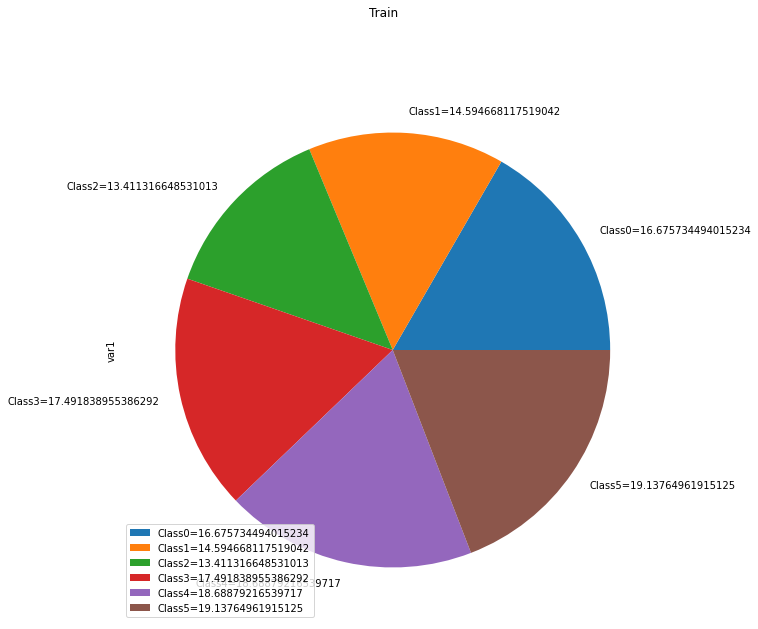

In [20]:
# train
df = pd.DataFrame({'var1':percent_train}, index=createLabel(percent_train))
df.plot(title='Train', kind='pie', subplots=True, figsize=(10,10))

**نمودار های مربوط به برخی ویژگی ها**

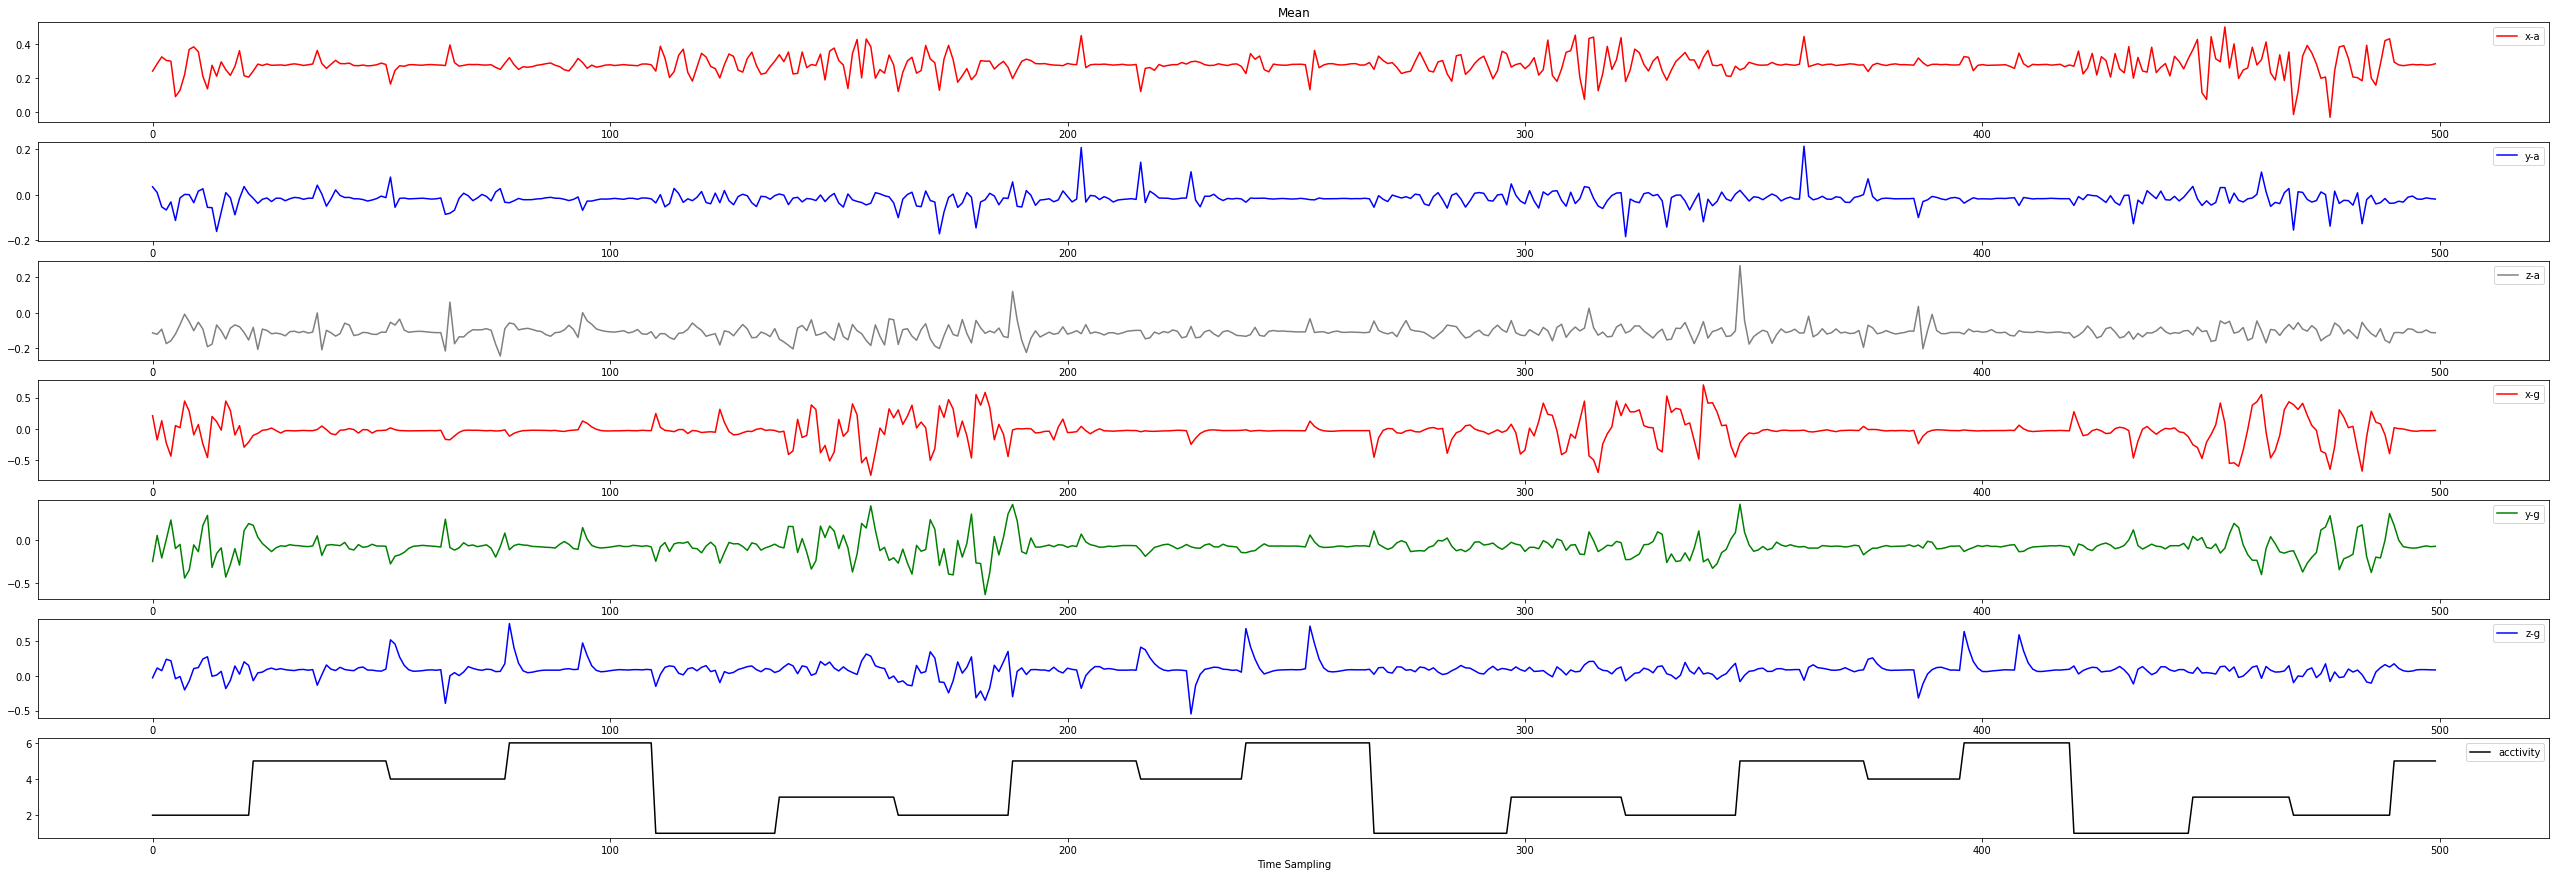

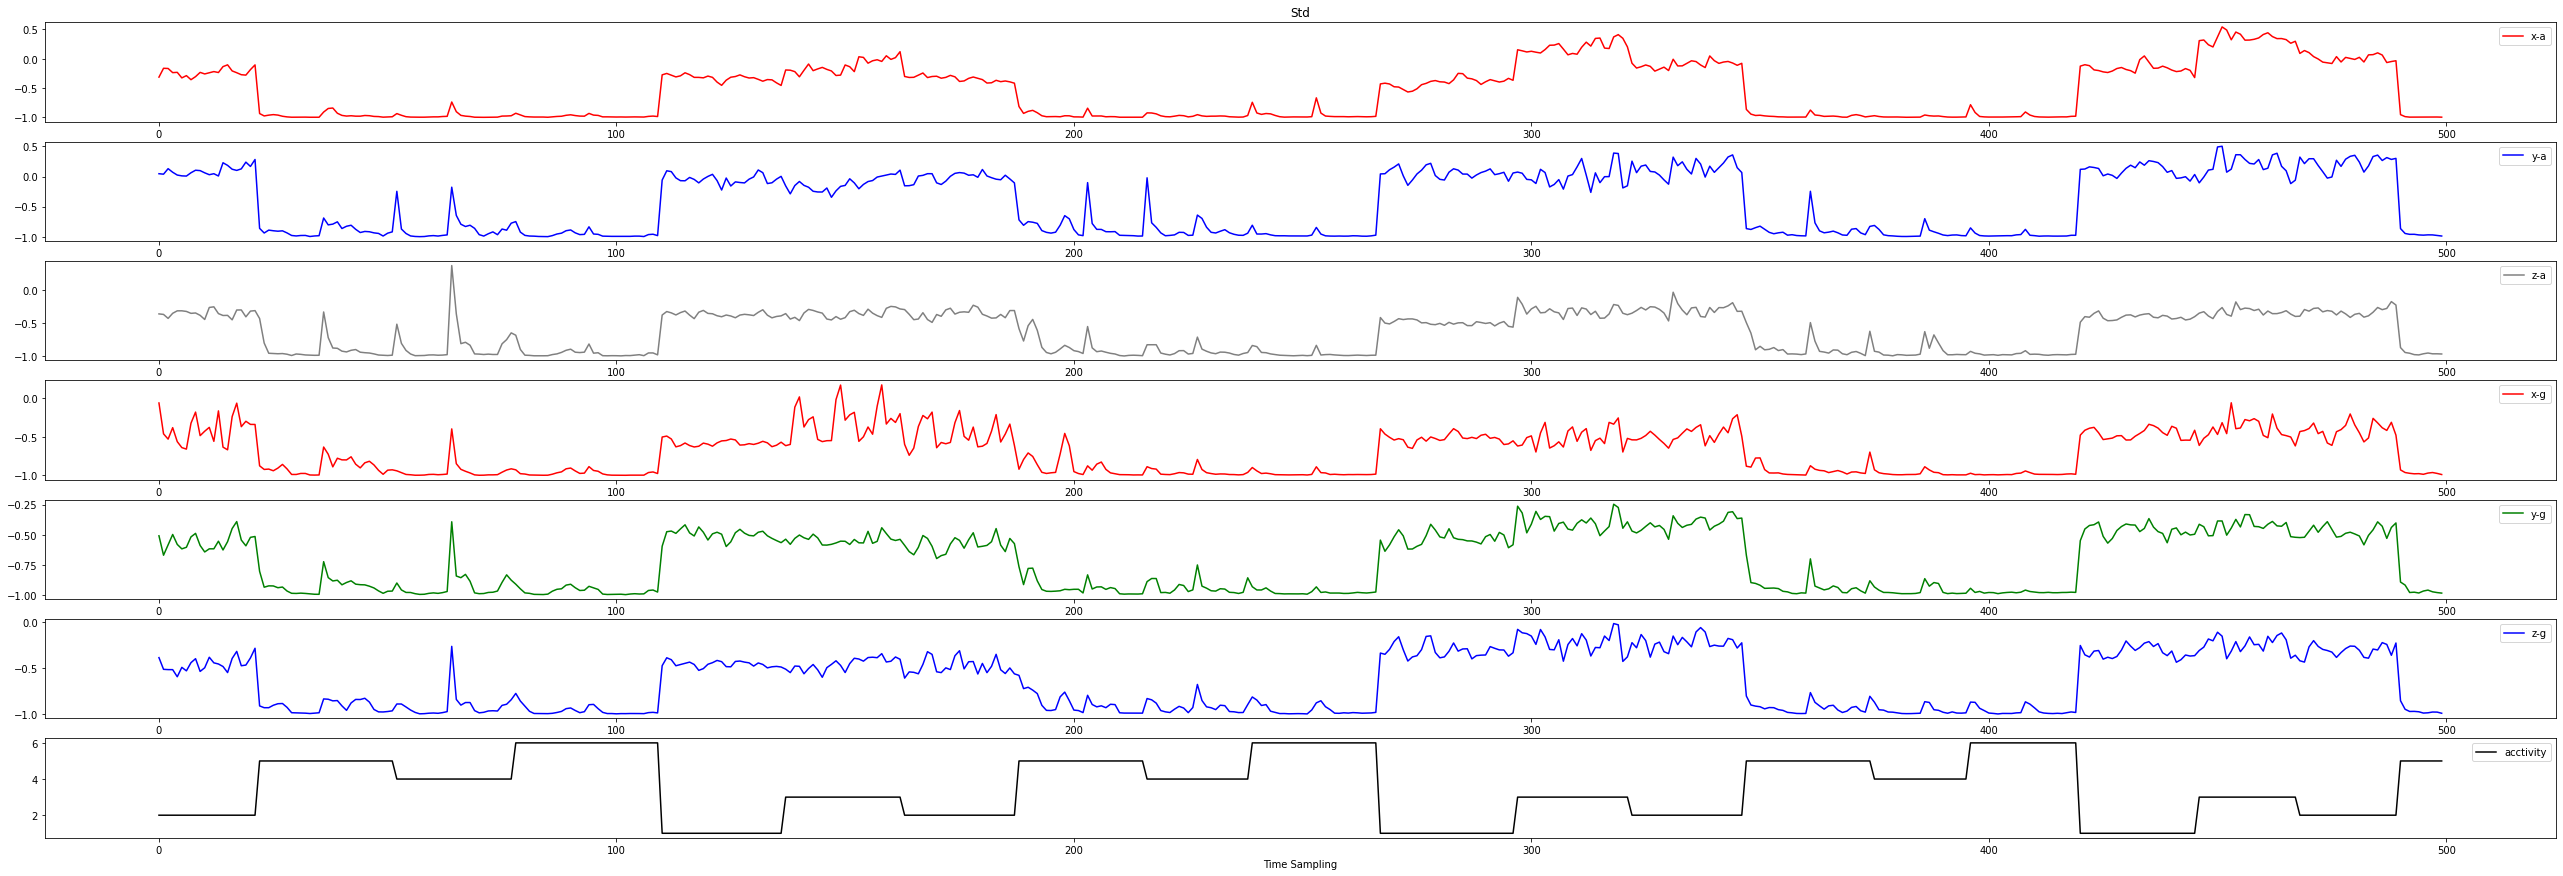

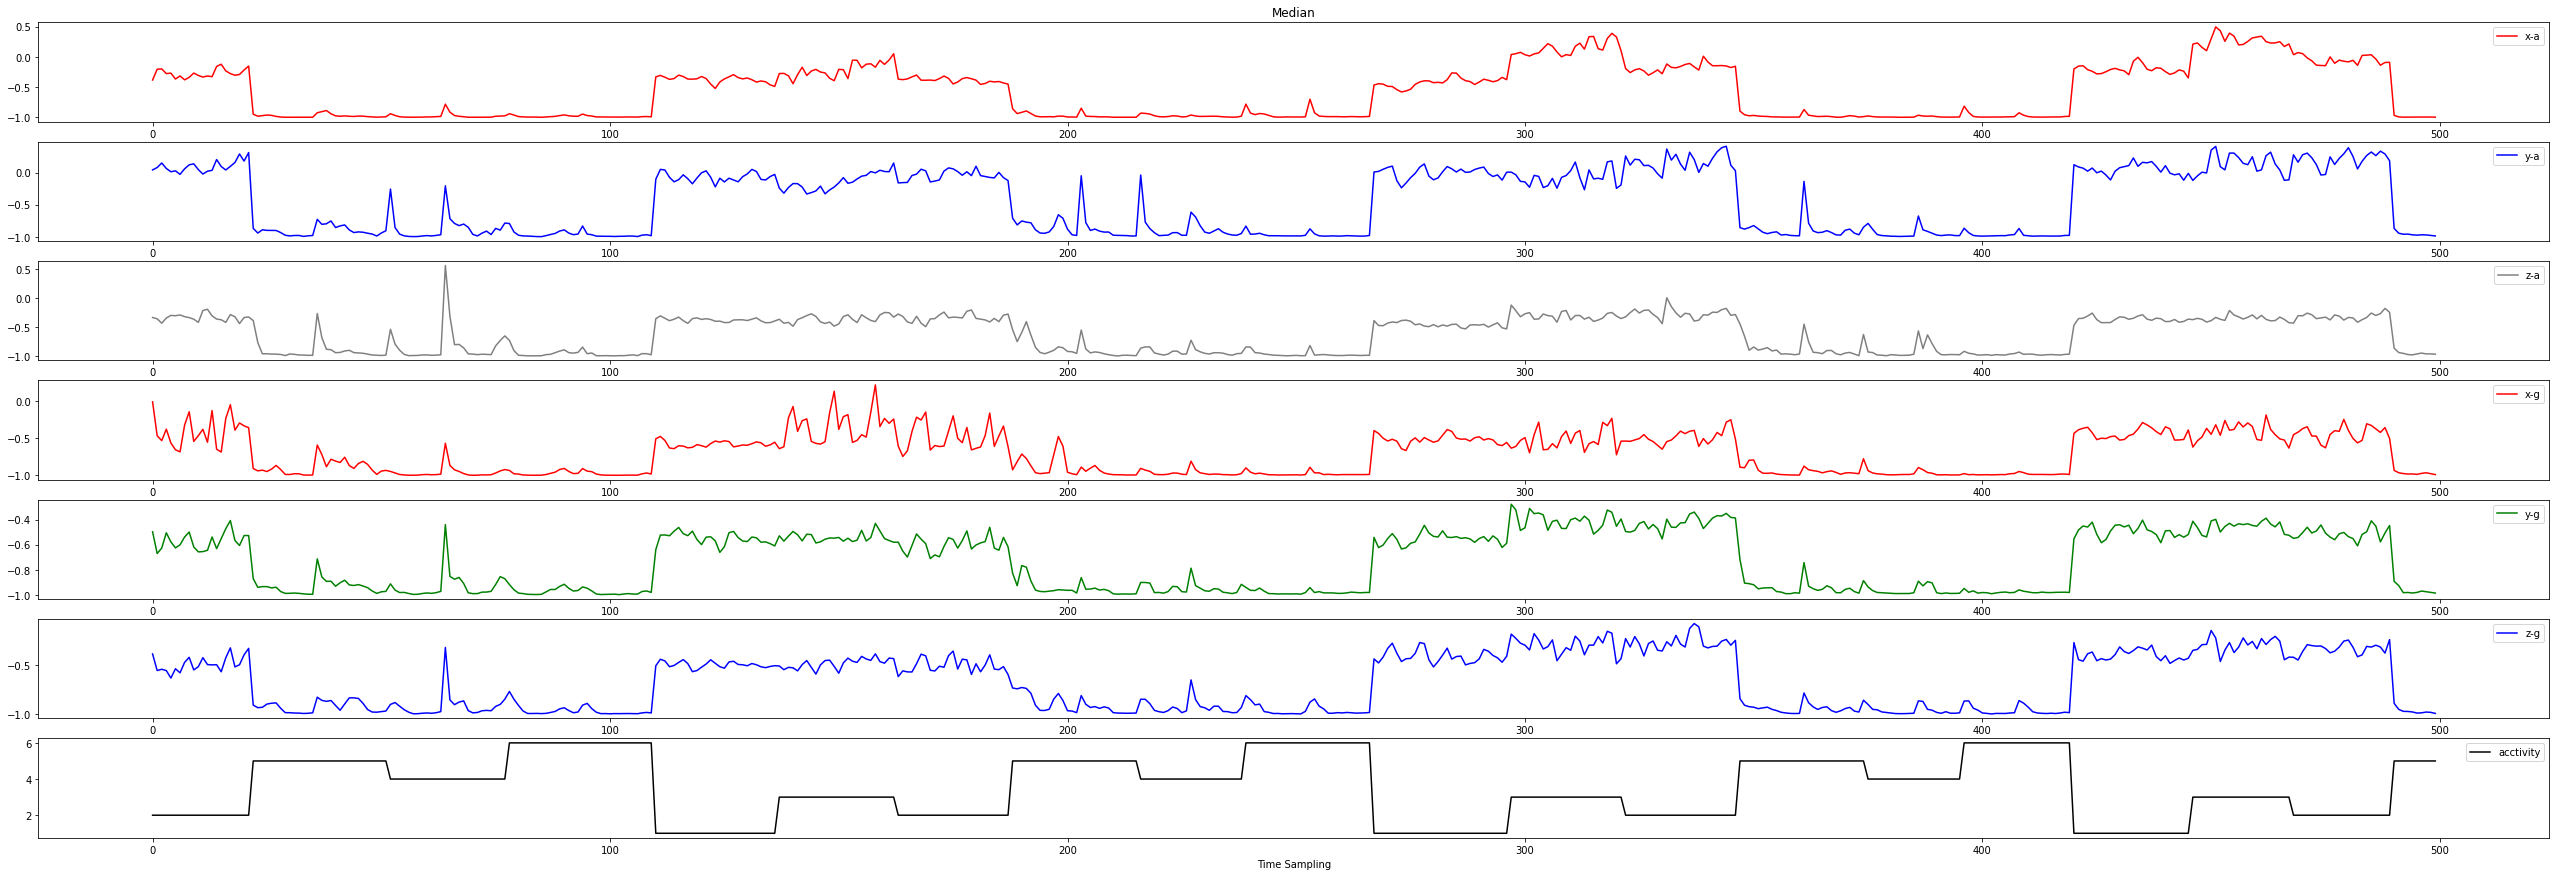

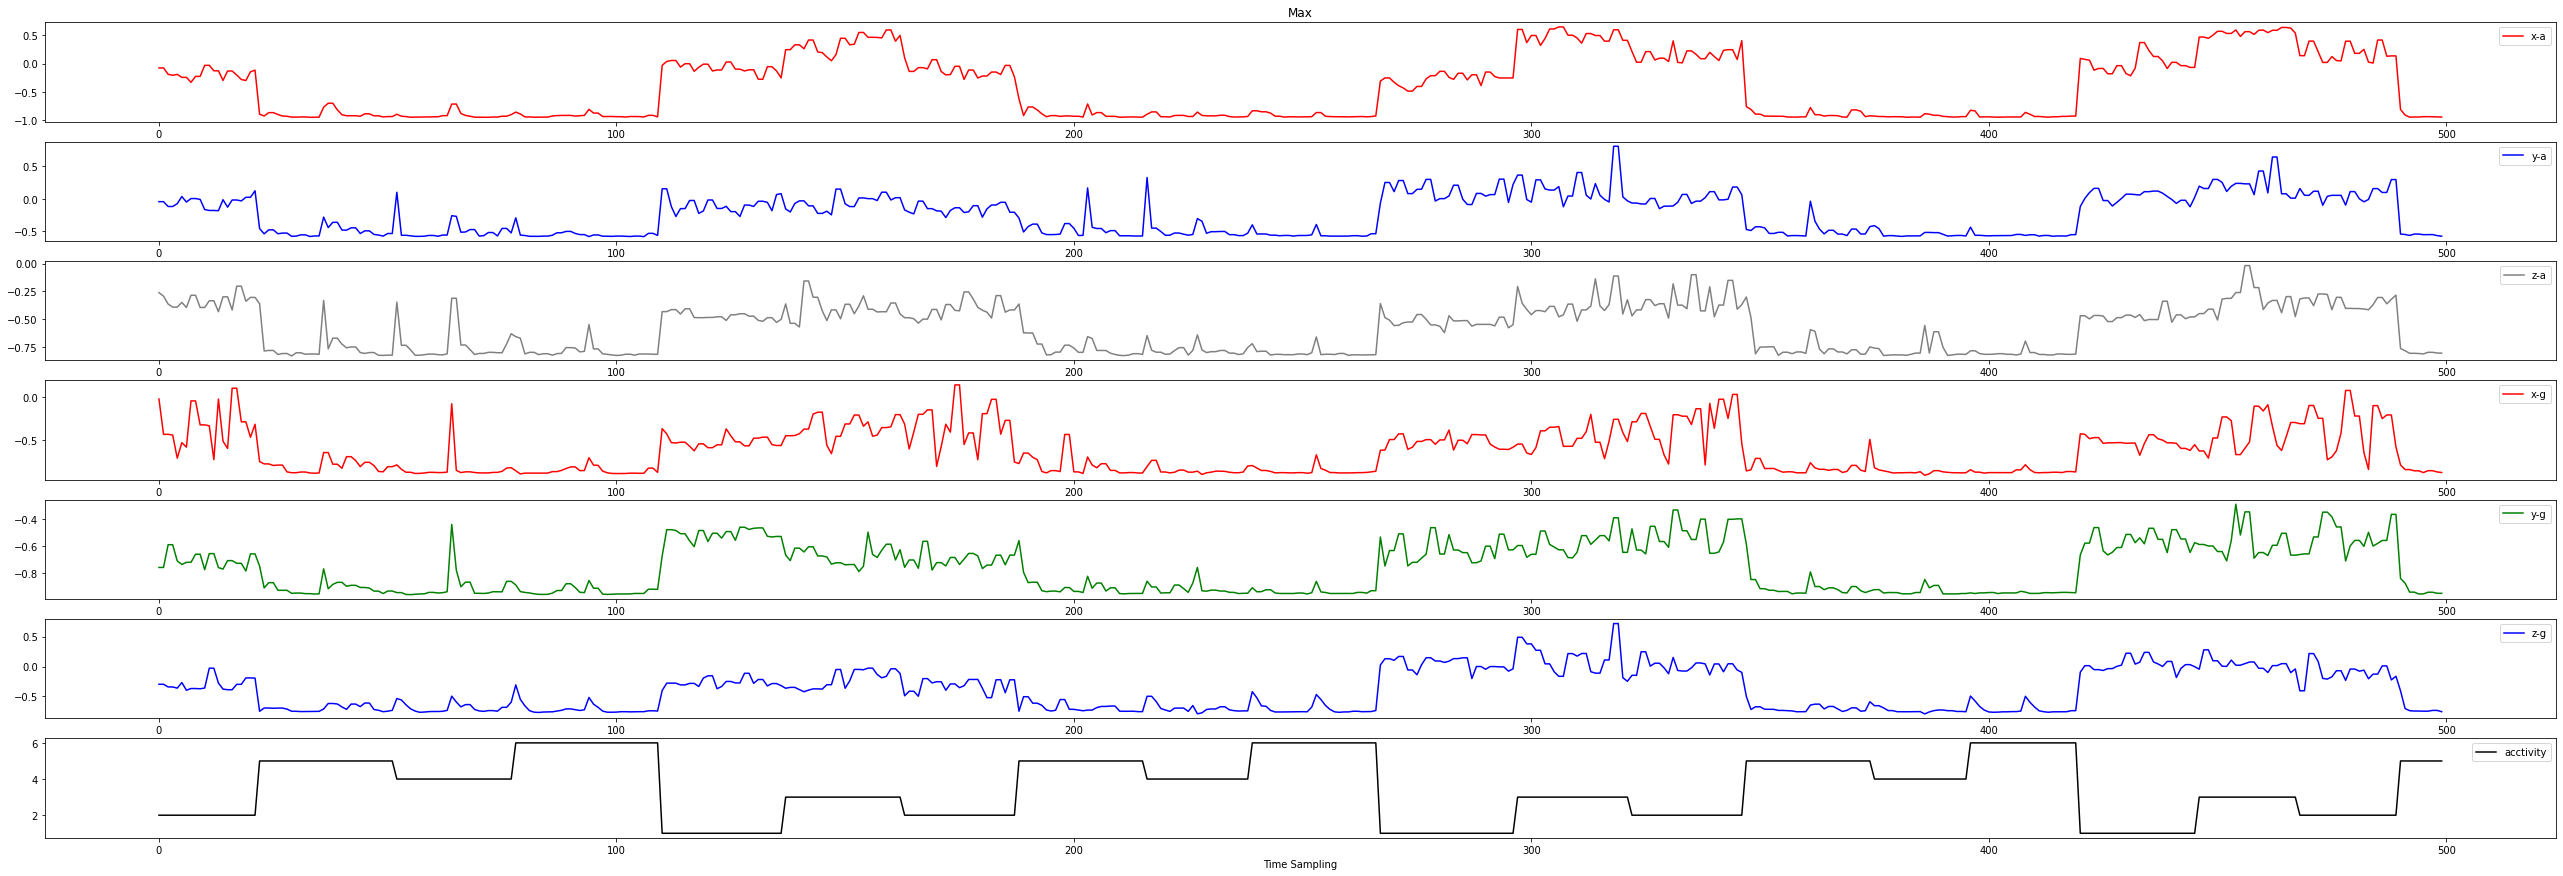

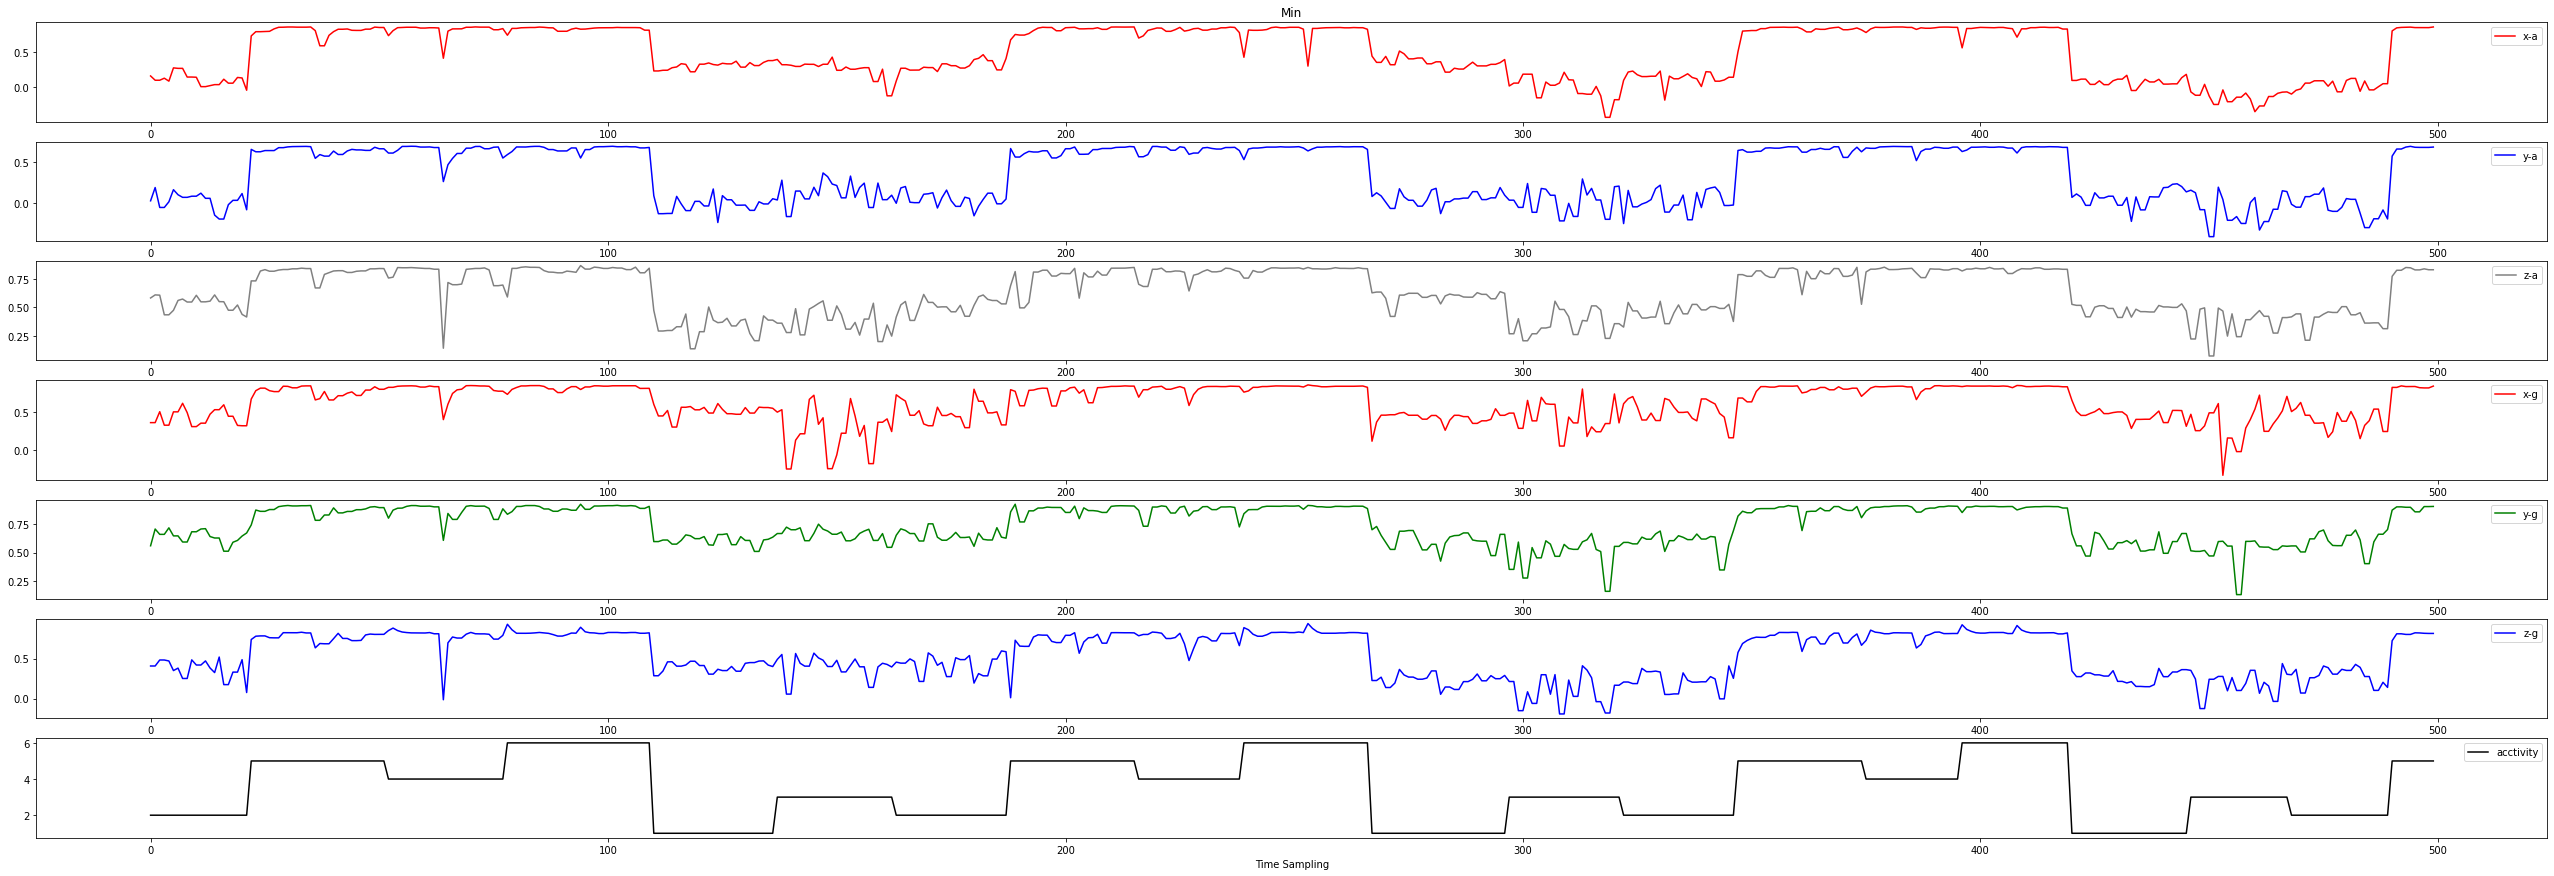

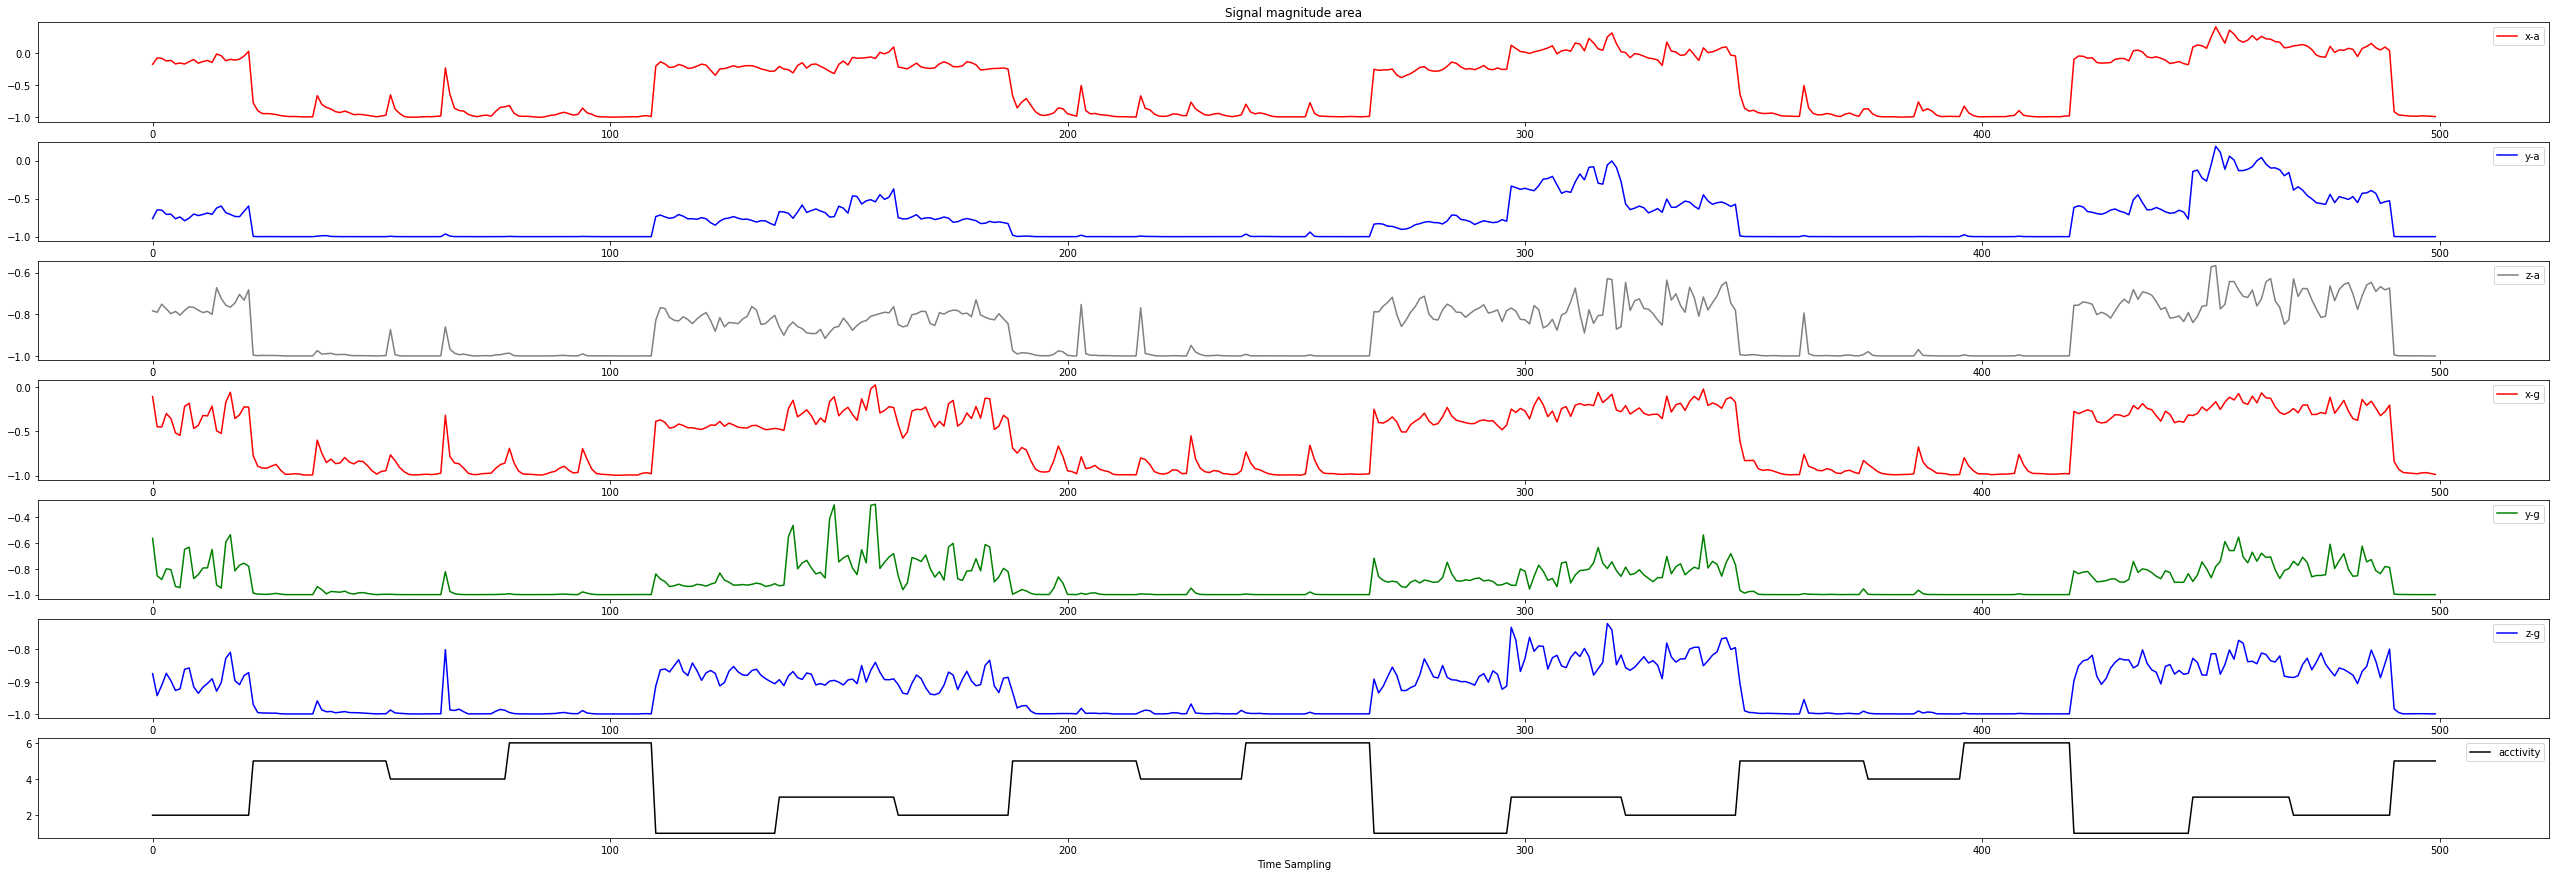

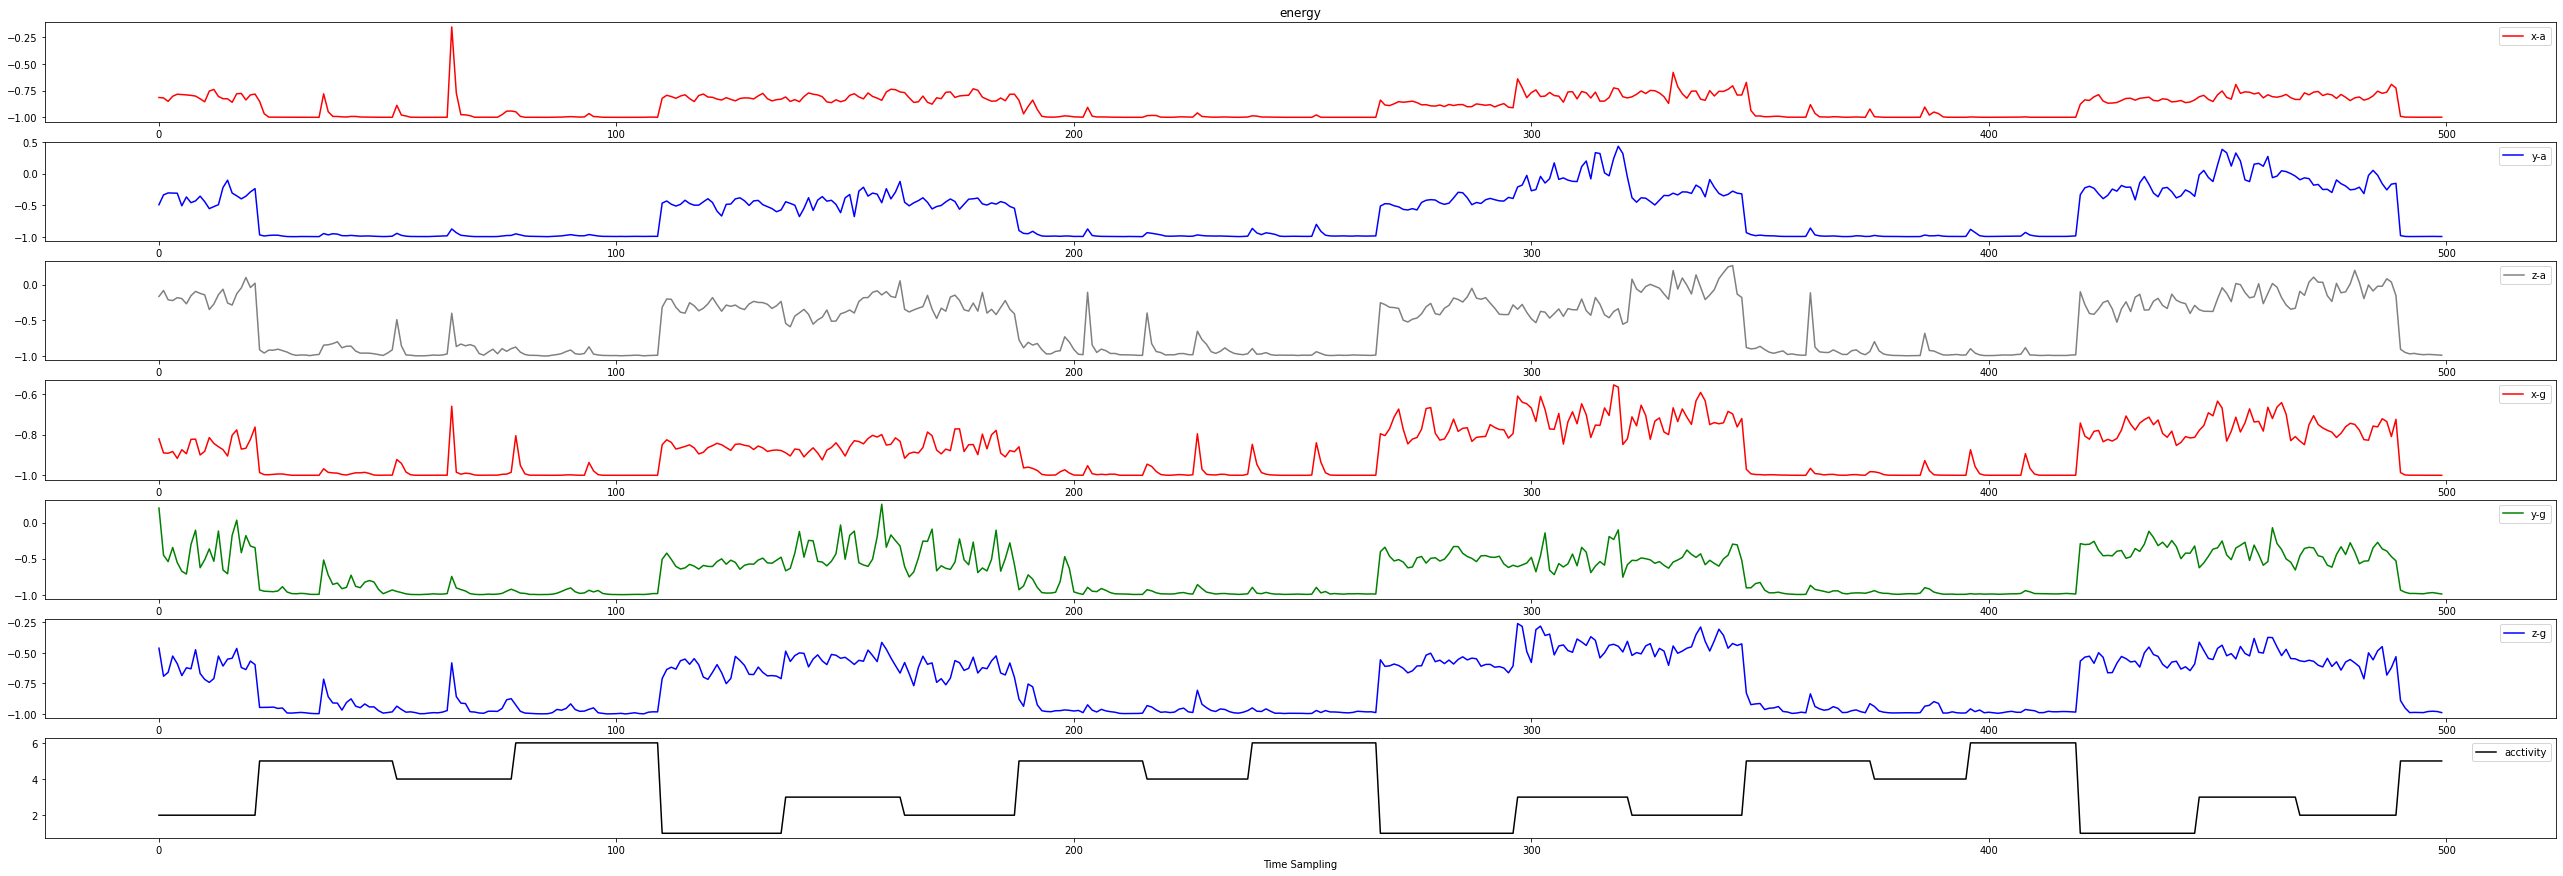

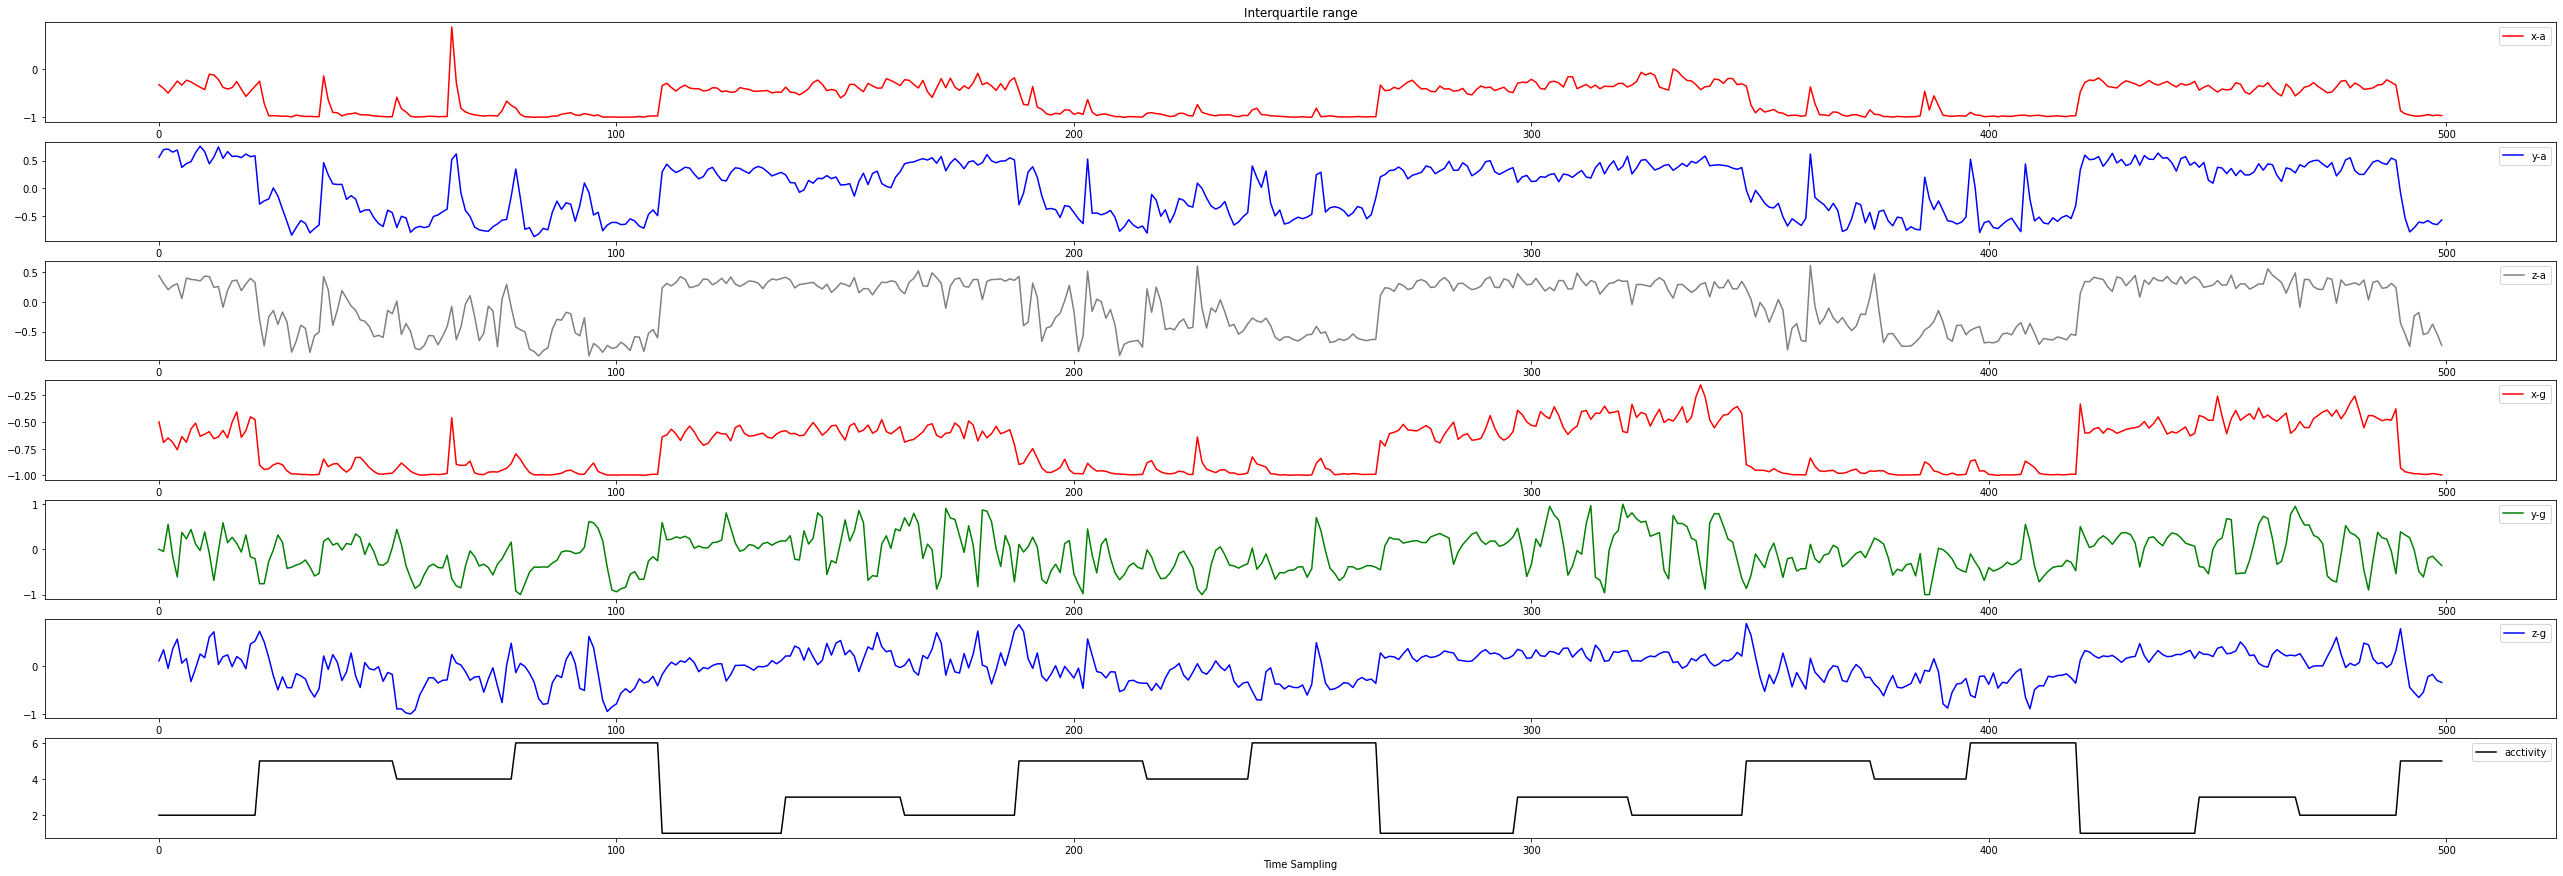

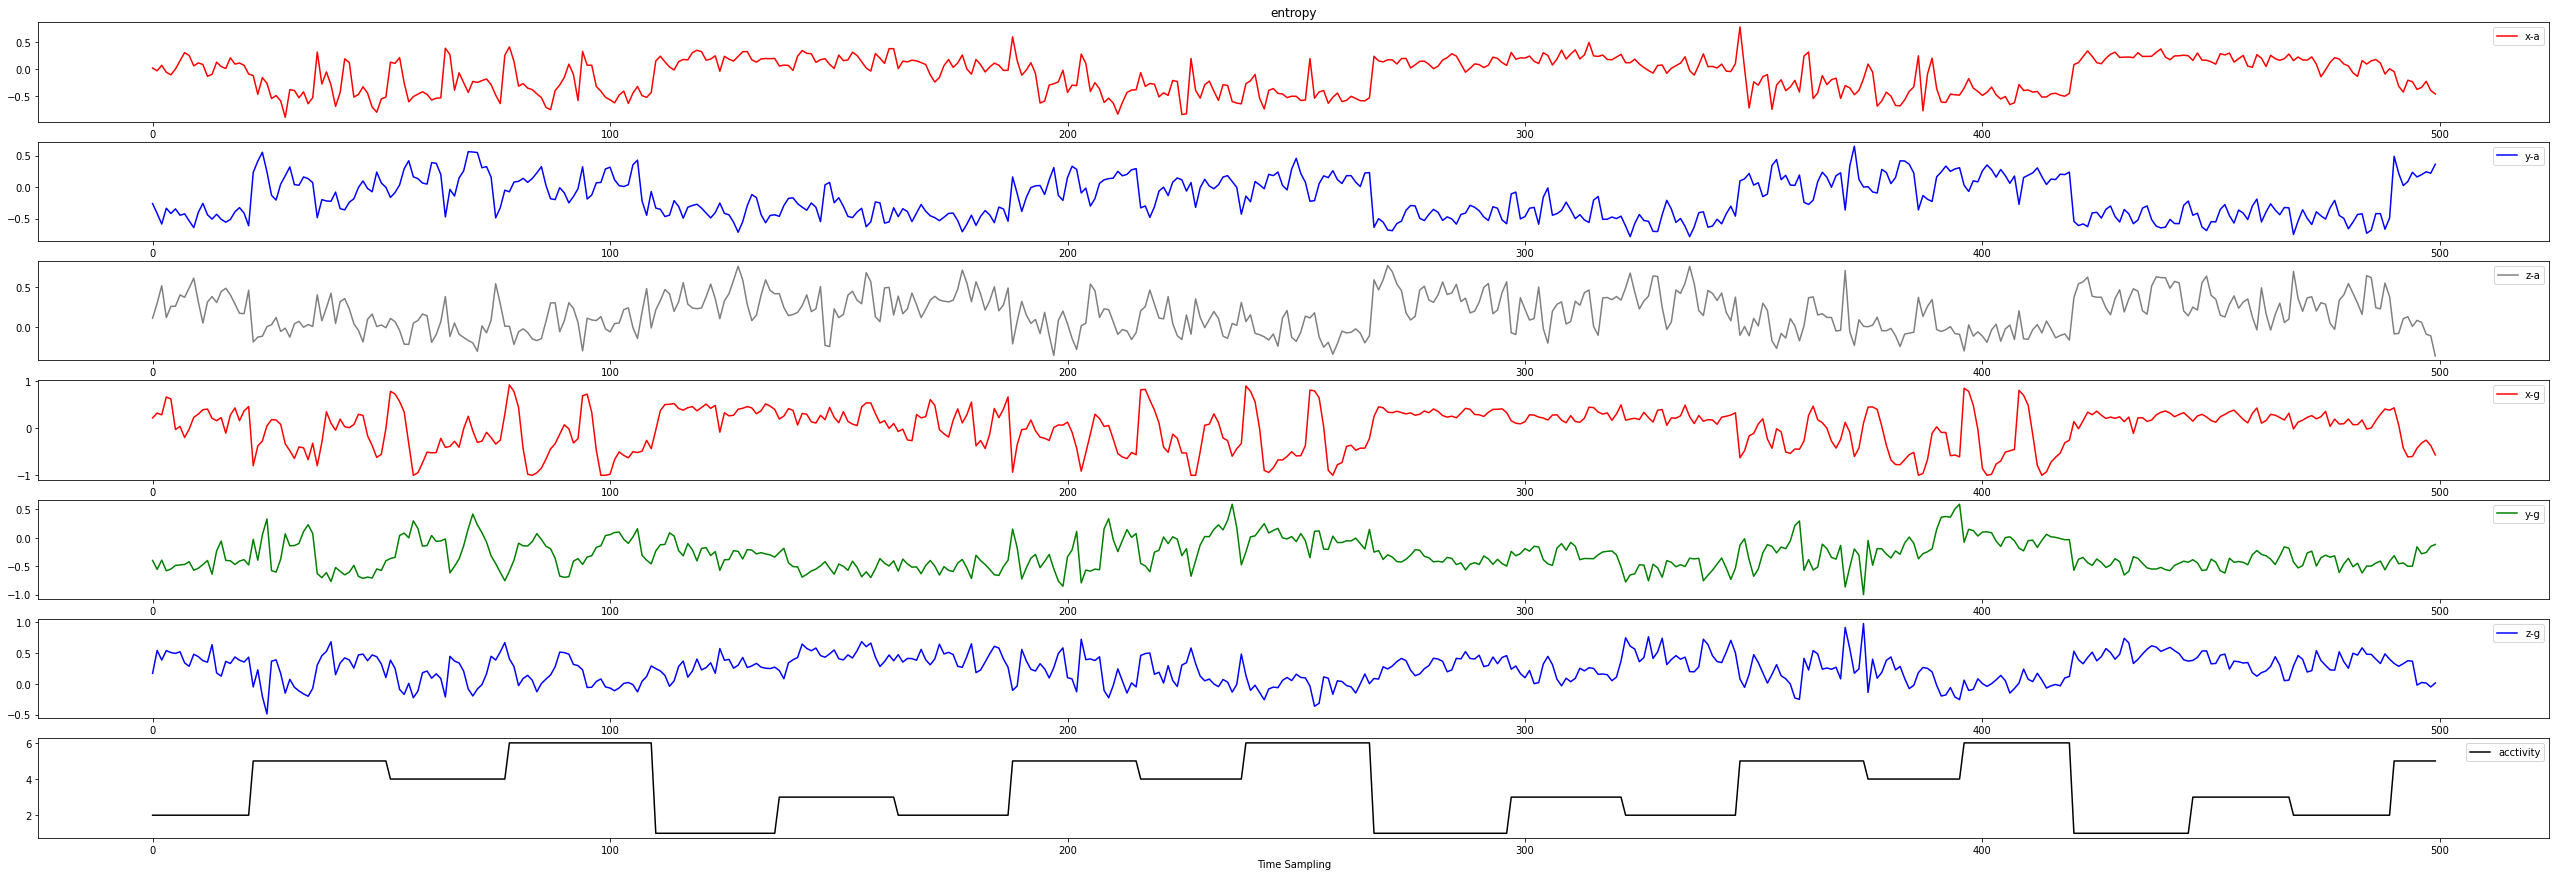

In [21]:
# plot features
start = 500
end = 1000

labels = ['Mean', 'Std', 'Median', 'Max', 'Min', 'Signal magnitude area', 'energy', 'Interquartile range', 'entropy']
showPlots(labels, start, end, trainy, trainx)

**تعریف مدل های یادگیری**

In [15]:
models = {}
models['MLP'] = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(64,32,16,8,6), random_state=1,max_iter=2000)
# nonlinear models
models['KNN'] = KNeighborsClassifier(n_neighbors=7)
models['DecisionTree'] = DecisionTreeClassifier()
models['SVM'] = SVC(kernel='rbf')
models['bayes'] = GaussianNB()
models['LogisticRegression'] = LogisticRegression(random_state=0,max_iter=2000)
# ensemble models
models['Bagging'] = BaggingClassifier(n_estimators=100)
models['RandomForest'] = RandomForestClassifier(n_estimators=100)
models['ExtraTrees'] = ExtraTreesClassifier(n_estimators=100)
models['GradientBoosting'] = GradientBoostingClassifier(n_estimators=100)
print('Defined %d models' % len(models))


Defined 10 models



# یادگیری و ارزیابی مدل ها با استفاده از تمامی ویژگی های دیتاست



*   در یادگیری به کارگیر گرفته شده استfeature.txt تمامی 561 ویژگی ذکر شده در فایل




In [0]:
def evaluate_model(trainX, trainy, testX, testy, model):
    # fit the model
    model.fit(trainX, trainy)
    # make predictions
    yhat = model.predict(testX)
    # evaluate predictions
    accuracy = accuracy_score(testy, yhat)
    cm = confusion_matrix(testy, yhat)
    return accuracy * 100.0, cm

In [0]:
# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(trainX, trainy, testX, testy, models):
    results = dict()
    cm = []
    i = 0
    for name, model in models.items():
        # evaluate the model
        cm.append(0)
        results[name], cm[i] = evaluate_model(trainX, trainy, testX, testy, model)
        # show process
        i = i + 1
        print('>%s: %.3f' % (name, results[name]))
    return results, cm

In [0]:
# print and plot the results
def summarize_results(results, maximize=True):
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k,v) for k,v in results.items()]
    # sort tuples by mean score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse for descending order (e.g. for accuracy)
    if maximize:
        mean_scores = list(reversed(mean_scores))
    print()
    for name, score in mean_scores:
        print('Name=%s, Score=%.3f' % (name, score))

جداسازی اطلاعات بعدا در بخش تفکیک درخت ها به کار گرفته میشود

In [0]:
def split_data(data,target):
    first_data  = []
    first_label = []
    second_data = []
    second_label= []
    for i in range(len(target)):
        if target[i] <= 4 :
            first_label.append(target[i])
            first_data.append(data[i,:])
        else :
            second_label.append(target[i])
            second_data.append(data[i,:])
    first_data = np.array(first_data)
    first_label = np.array(first_label)
    second_data = np.array(second_data)
    second_label = np.array(second_label)
    return first_data,first_label,second_data,second_label

In [0]:
def evaluate_trees(model,X_test,y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return cm , accuracy * 100

In [0]:
def extract_trees(model,X_test,y_test):
    cm_rf =[]
    accuracy_rf = []
    for i in range(len(model.estimators_)):
        tree = model.estimators_[i]
        cm_rf.append(0)
        accuracy_rf.append(0)
        cm_rf[i], accuracy_rf[i] = evaluate_trees(tree,X_test,y_test)
        print(cm_rf[i])
        print(accuracy_rf[i])
    return cm_rf, accuracy_rf

In [0]:
def accuracy_cal(cm):
    acc = []
    for i in range(len(cm[0,:])):
        acc.append(0)
        acc[i] = cm[i,i] / sum(cm[i,:])
    return acc

In [0]:
def each_claas_accuracy(cm):
    cm_acc = []
    for i in range(len(cm)) :
        cm_acc.append(0)
        cm_acc[i] = accuracy_cal(cm[i])
        print(cm_acc[i])
    return cm_acc

In [0]:
def total_acc(num_a, acc_a, num_b, acc_b):
    res = []
    for i in range(len(acc_a)):
        res.append(0)
        res[i] = (acc_a[i] * num_a + acc_b[i] * num_b)/(num_a + num_b)
    return res

In [0]:
seed = 17
np.random.seed(seed)

In [26]:
print(trainx.shape,trainy.shape,testx.shape,testy.shape)

(7352, 561) (7352, 1) (2947, 561) (2947, 1)


In [0]:
# normalize
sc = StandardScaler()

# TODO : data has normilized before creating feature's data

In [0]:
first_data, first_label, second_data, second_label  = split_data(trainx,trainy)

In [29]:
print(first_data.shape,first_label.shape,second_data.shape,second_label.shape)

(4571, 561) (4571, 1) (2781, 561) (2781, 1)


نتایج به دست آمده از یادگیری مدل ها با کمک 561 وِیژگی و بدون استاندارد کردن داده ها

In [37]:
results1, cm1 = evaluate_models(trainx, trainy.ravel() , testx , testy.ravel() , models)

>MLP: 94.673
>KNN: 90.329
>DecisionTree: 86.325
>SVM: 95.046
>bayes: 77.027
>LogisticRegression: 96.132
>Bagging: 89.956
>RandomForest: 92.365
>ExtraTrees: 93.824
>GradientBoosting: 93.892


In [38]:
print(trainx.shape,trainy.shape)

(7352, 561) (7352, 1)


بر روی داده ها بدون استاندارد کردن ویژگی ها logist regression اعمال 

In [39]:
# fit the model
models['LogisticRegression'].fit(trainx, trainy.ravel())
# make predictions
yhat = models['LogisticRegression'].predict(testx)
# evaluate predictions
accuracy = accuracy_score(testy, yhat)
cm = confusion_matrix(testy, yhat)
print(accuracy)

0.9613165931455717


In [40]:
print(trainx.mean(axis=0))
print(trainx.std(axis=0))

[ 0.27448812 -0.01769543 -0.10914102 -0.60543845 -0.51093756 -0.60475369
 -0.63051213 -0.52690743 -0.60615048 -0.46860401 -0.30604316 -0.55712062
  0.52355074  0.38738551  0.5943743  -0.54756889 -0.82004093 -0.90187352
 -0.84578393 -0.68434492 -0.64376963 -0.63106863 -0.10299256 -0.13793729
 -0.16394559 -0.11659865  0.10276195 -0.0377855   0.13047687 -0.02622921
  0.02632185  0.15996554 -0.01957489  0.00941957  0.03329057  0.03658658
 -0.07864015 -0.12513058 -0.19380232  0.10500509  0.66412189  0.01100604
  0.09392027 -0.96452258 -0.95368372 -0.93692889 -0.96533626 -0.95468342
 -0.9382705   0.60416484 -0.00328247  0.09895917  0.67850473  0.02324803
  0.08061402 -0.07833469  0.43671056 -0.73037943 -0.744705   -0.96756685
 -0.95803908 -0.94300195 -0.66750808 -0.8691348  -0.68471511 -0.51577064
  0.55317723 -0.58990754  0.62601856 -0.34532838  0.33094389 -0.36037876
  0.40735358 -0.43114965  0.45629067 -0.48082955  0.50212196  0.18680917
 -0.10527683  0.08867061  0.07912588  0.00855545 -0

کردن داده های تست وآموزش به صورت جداگانه و اعمال مجدد یادگیری scale

In [0]:
from sklearn import preprocessing
trainx_scaled = preprocessing.scale(trainx)
testx_scaled = preprocessing.scale(testx)

In [42]:
# fit the model
models['LogisticRegression'].fit(trainx_scaled, trainy.ravel())
# make predictions
yhat = models['LogisticRegression'].predict(testx_scaled)
# evaluate predictions
accuracy = accuracy_score(testy, yhat)
cm = confusion_matrix(testy, yhat)
print(accuracy)

0.9640312181879878


استاندارد کردن داده های تست و آموزش به صورت یکسان و اعمال مجدد یادگیری

In [0]:
scaler = preprocessing.StandardScaler().fit(trainx)
trainx_scaled2 = scaler.transform(trainx)
testx_scaled2 = scaler.transform(testx)

In [44]:
# fit the model
models['LogisticRegression'].fit(trainx_scaled2, trainy.ravel())
# make predictions
yhat = models['LogisticRegression'].predict(testx_scaled2)
# evaluate predictions
accuracy = accuracy_score(testy, yhat)
cm = confusion_matrix(testy, yhat)
print(accuracy)

0.9548693586698337


کردن داده های آموزش و تست به صورت یکجا و اعمال مجدد یادگیری scale 

In [45]:
dd = np.concatenate((trainx,testx))
dd_scaled = preprocessing.scale(dd)

trainx_scaled3 = dd_scaled[0:7352]
testx_scaled3 = dd_scaled[7352:10299]

print(trainx_scaled3.shape)
print(testx_scaled3.shape)

# fit the model
models['LogisticRegression'].fit(trainx_scaled3, trainy.ravel())
# make predictions
yhat = models['LogisticRegression'].predict(testx_scaled3)
# evaluate predictions
accuracy = accuracy_score(testy, yhat)
cm = confusion_matrix(testy, yhat)
print(accuracy)

(7352, 561)
(2947, 561)
0.9555480149304377


**بررسی دقیق تر نتایج به دست آمده از مدل های اصلی**

In [49]:
summarize_results(results1,True)


Name=LogisticRegression, Score=96.132
Name=SVM, Score=95.046
Name=MLP, Score=94.673
Name=GradientBoosting, Score=93.892
Name=ExtraTrees, Score=93.824
Name=RandomForest, Score=92.365
Name=KNN, Score=90.329
Name=Bagging, Score=89.956
Name=DecisionTree, Score=86.325
Name=bayes, Score=77.027


In [158]:
cm1

[array([[480,  16,   0,   0,   0,   0],
        [ 41, 429,   1,   0,   0,   0],
        [  4,  35, 381,   0,   0,   0],
        [  2,   0,   0, 445,  44,   0],
        [  0,   0,   0,  14, 518,   0],
        [  0,   0,   0,   0,   0, 537]]),
 array([[482,   3,  11,   0,   0,   0],
        [ 42, 423,   6,   0,   0,   0],
        [ 48,  40, 332,   0,   0,   0],
        [  0,   4,   0, 394,  93,   0],
        [  0,   0,   0,  35, 497,   0],
        [  0,   0,   0,   2,   1, 534]]),
 array([[461,  14,  21,   0,   0,   0],
        [ 79, 361,  31,   0,   0,   0],
        [ 24,  46, 350,   0,   0,   0],
        [  0,   0,   0, 375, 116,   0],
        [  0,   0,   0,  72, 460,   0],
        [  0,   0,   0,   0,   0, 537]]),
 array([[488,   5,   3,   0,   0,   0],
        [ 20, 451,   0,   0,   0,   0],
        [ 10,  26, 384,   0,   0,   0],
        [  0,   2,   0, 438,  51,   0],
        [  0,   0,   0,  29, 503,   0],
        [  0,   0,   0,   0,   0, 537]]),
 array([[416,  38,  42,   0,   0

In [62]:
yhat = models['LogisticRegression'].predict(testx_scaled2)
# evaluate predictions
accuracy = accuracy_score(testy, yhat)
cm = confusion_matrix(testy, yhat)
print(accuracy)

0.9511367492365117


In [0]:
def draw_confussion_matrix(truth_y,predicted_y,title):
    labels = find_activity_name()
    cm = confusion_matrix(truth_y, predicted_y)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels,rotation=45,va="center", position=(0,-0.28),color='blue')
    ax.set_yticklabels([''] + labels,color='blue')
    ax.title.set_text('confusion matrix of %s'% title)
    ax.title.set_color('red')
    plt.xlabel('Predicted',color='yellow')
    plt.ylabel('True',color='yellow')
    plt.show()


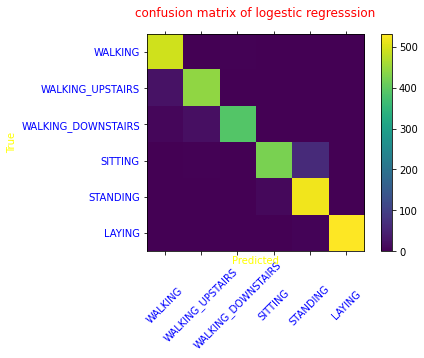

In [105]:
draw_confussion_matrix(testy,yhat,'logestic regresssion')

In [0]:
def draw_confussion_matrices(truth_y,cms,titles):
    i = 1
    fig = plt.figure(figsize=(17,17))
    #labels = find_activity_name()
    labels = ['walk','walk U','walk D','sit','stand','lay']

    for cm in cms:
        ax = fig.add_subplot(4,3,i)
        cax = ax.matshow(cm)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels,rotation=45,va="center", position=(0,-0.13),color='blue')
        ax.set_yticklabels([''] + labels,color='blue')
        ax.title.set_text('confusion matrix of %s'% titles[i-1])
        ax.title.set_color('red')
        plt.xlabel('Predicted',color='yellow')
        plt.ylabel('True',color='yellow')
        i = i+1
        
    fig.tight_layout(pad=3)    
    plt.show()

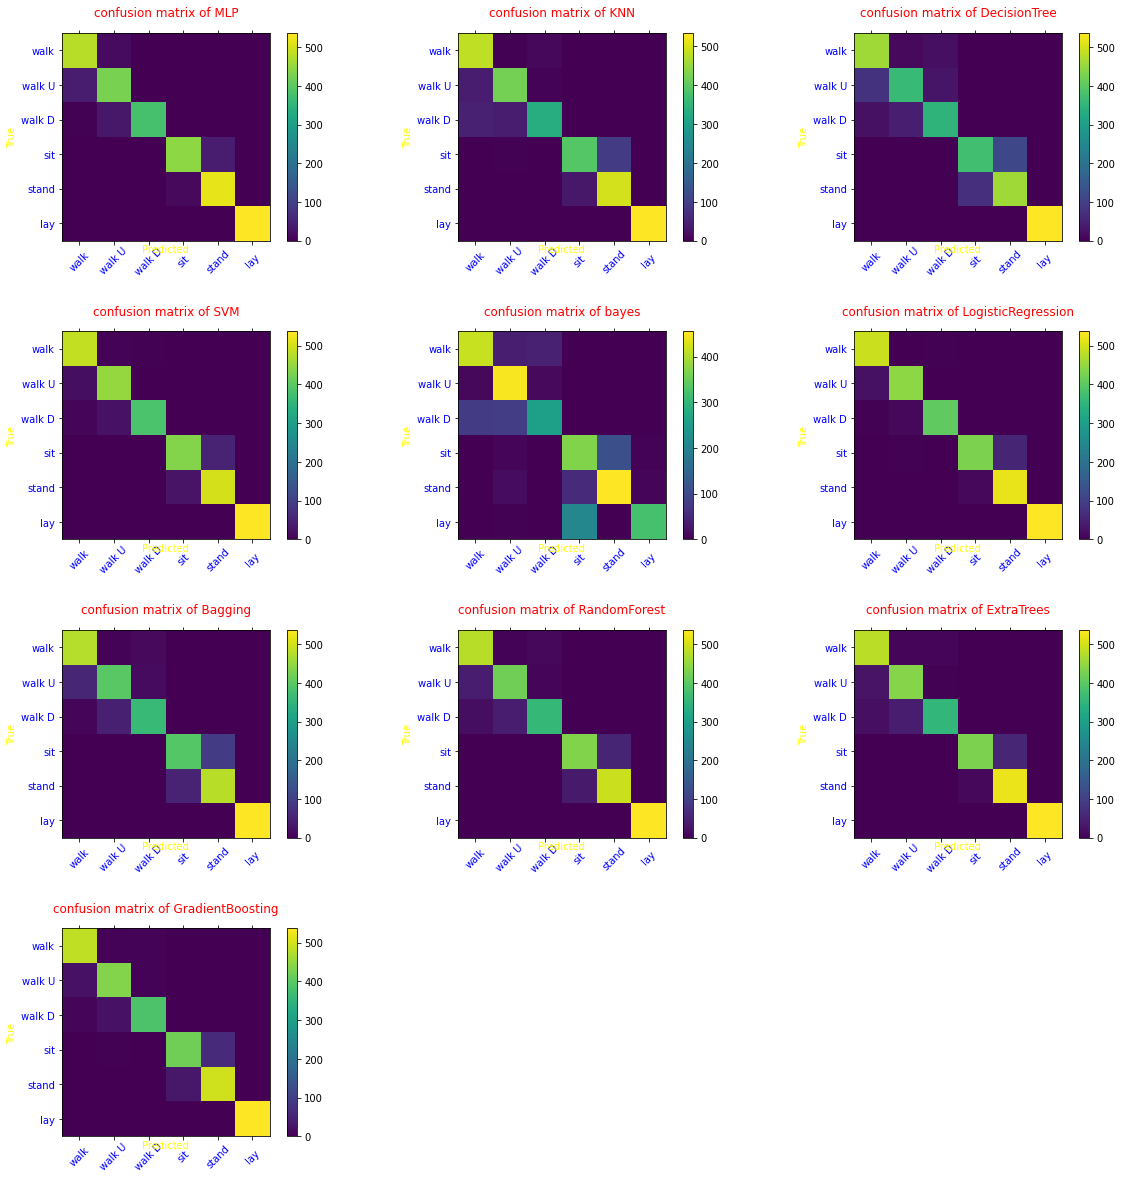

In [180]:
model_names = [name for name,model in models.items() ]

draw_confussion_matrices(testy,cm1,model_names)

#های منتخب feature یادگیری و ارزیابی مدل ها با استفاده از 


In [0]:
features_list = load_file('UCI HAR Dataset/features.txt')
features_dict = {num:name for num,name in features_list}

In [51]:
features_list

array([[1, 'tBodyAcc-mean()-X'],
       [2, 'tBodyAcc-mean()-Y'],
       [3, 'tBodyAcc-mean()-Z'],
       ...,
       [559, 'angle(X,gravityMean)'],
       [560, 'angle(Y,gravityMean)'],
       [561, 'angle(Z,gravityMean)']], dtype=object)

In [52]:
features_dict

{1: 'tBodyAcc-mean()-X',
 2: 'tBodyAcc-mean()-Y',
 3: 'tBodyAcc-mean()-Z',
 4: 'tBodyAcc-std()-X',
 5: 'tBodyAcc-std()-Y',
 6: 'tBodyAcc-std()-Z',
 7: 'tBodyAcc-mad()-X',
 8: 'tBodyAcc-mad()-Y',
 9: 'tBodyAcc-mad()-Z',
 10: 'tBodyAcc-max()-X',
 11: 'tBodyAcc-max()-Y',
 12: 'tBodyAcc-max()-Z',
 13: 'tBodyAcc-min()-X',
 14: 'tBodyAcc-min()-Y',
 15: 'tBodyAcc-min()-Z',
 16: 'tBodyAcc-sma()',
 17: 'tBodyAcc-energy()-X',
 18: 'tBodyAcc-energy()-Y',
 19: 'tBodyAcc-energy()-Z',
 20: 'tBodyAcc-iqr()-X',
 21: 'tBodyAcc-iqr()-Y',
 22: 'tBodyAcc-iqr()-Z',
 23: 'tBodyAcc-entropy()-X',
 24: 'tBodyAcc-entropy()-Y',
 25: 'tBodyAcc-entropy()-Z',
 26: 'tBodyAcc-arCoeff()-X,1',
 27: 'tBodyAcc-arCoeff()-X,2',
 28: 'tBodyAcc-arCoeff()-X,3',
 29: 'tBodyAcc-arCoeff()-X,4',
 30: 'tBodyAcc-arCoeff()-Y,1',
 31: 'tBodyAcc-arCoeff()-Y,2',
 32: 'tBodyAcc-arCoeff()-Y,3',
 33: 'tBodyAcc-arCoeff()-Y,4',
 34: 'tBodyAcc-arCoeff()-Z,1',
 35: 'tBodyAcc-arCoeff()-Z,2',
 36: 'tBodyAcc-arCoeff()-Z,3',
 37: 'tBodyAcc-arCoef

In [71]:
def find_features_index(features_list,selected_features_names):
    return [num for num,name in features_list if name in selected_features_names]


t = find_features_index(features_list,['tBodyAcc-mean()-X','tBodyAcc-mean()-Z'])
print(t)

[1, 3]


In [0]:
selected_features = [
    'tBodyAcc-mean()-X',
    'tBodyAcc-mean()-Y',
    'tBodyAcc-mean()-Z',
    'tBodyAcc-min()-X',
    'tBodyAcc-min()-Y',
    'tBodyAcc-min()-Z',
    'tBodyAcc-max()-X',
    'tBodyAcc-max()-Y',
    'tBodyAcc-max()-Z',
    'tBodyAcc-std()-X',
    'tBodyAcc-std()-Y',
    'tBodyAcc-std()-Z',
    
    'tBodyAcc-mad()-X',
    'tBodyAcc-mad()-Y',
    'tBodyAcc-mad()-Z',
    'tBodyAcc-iqr()-X',
    'tBodyAcc-iqr()-Y',
    'tBodyAcc-iqr()-Z',
    'fBodyAcc-skewness()-X',
    'fBodyAcc-skewness()-Y',
    'fBodyAcc-skewness()-Z',
    'fBodyAcc-kurtosis()-X',
    'fBodyAcc-kurtosis()-Y',
    'fBodyAcc-kurtosis()-Z', 
]

In [0]:
selected_featrues_index = find_features_index(features_list,selected_features)

In [143]:
selected_featrues_index 

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 20,
 21,
 22,
 297,
 298,
 299,
 300,
 301,
 302]

In [144]:
models = {}
models['MLP'] = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(64,32,16,8,6), random_state=1,max_iter=2000)
# nonlinear models
models['KNN'] = KNeighborsClassifier(n_neighbors=7)
models['DecisionTree'] = DecisionTreeClassifier()
models['SVM'] = SVC(kernel='rbf')
models['bayes'] = GaussianNB()
models['LogisticRegression'] = LogisticRegression(random_state=0,max_iter=2000)
# ensemble models
models['Bagging'] = BaggingClassifier(n_estimators=100)
models['RandomForest'] = RandomForestClassifier(n_estimators=100)
models['ExtraTrees'] = ExtraTreesClassifier(n_estimators=100)
models['GradientBoosting'] = GradientBoostingClassifier(n_estimators=100)
print('Defined %d models' % len(models))


Defined 10 models


In [145]:
selected_trainx = trainx[:,selected_featrues_index]
selected_testx = testx[:,selected_featrues_index]
print(trainx.shape)
print(selected_trainx.shape)

(7352, 561)
(7352, 24)


In [146]:
results2, cm2 = evaluate_models(selected_trainx, trainy.ravel() , selected_testx , testy.ravel() , models)

>MLP: 43.468
>KNN: 65.185
>DecisionTree: 64.438
>SVM: 68.103
>bayes: 51.985
>LogisticRegression: 69.562
>Bagging: 73.193
>RandomForest: 74.279
>ExtraTrees: 74.584
>GradientBoosting: 73.566


In [147]:
summarize_results(results2,True)


Name=ExtraTrees, Score=74.584
Name=RandomForest, Score=74.279
Name=GradientBoosting, Score=73.566
Name=Bagging, Score=73.193
Name=LogisticRegression, Score=69.562
Name=SVM, Score=68.103
Name=KNN, Score=65.185
Name=DecisionTree, Score=64.438
Name=bayes, Score=51.985
Name=MLP, Score=43.468


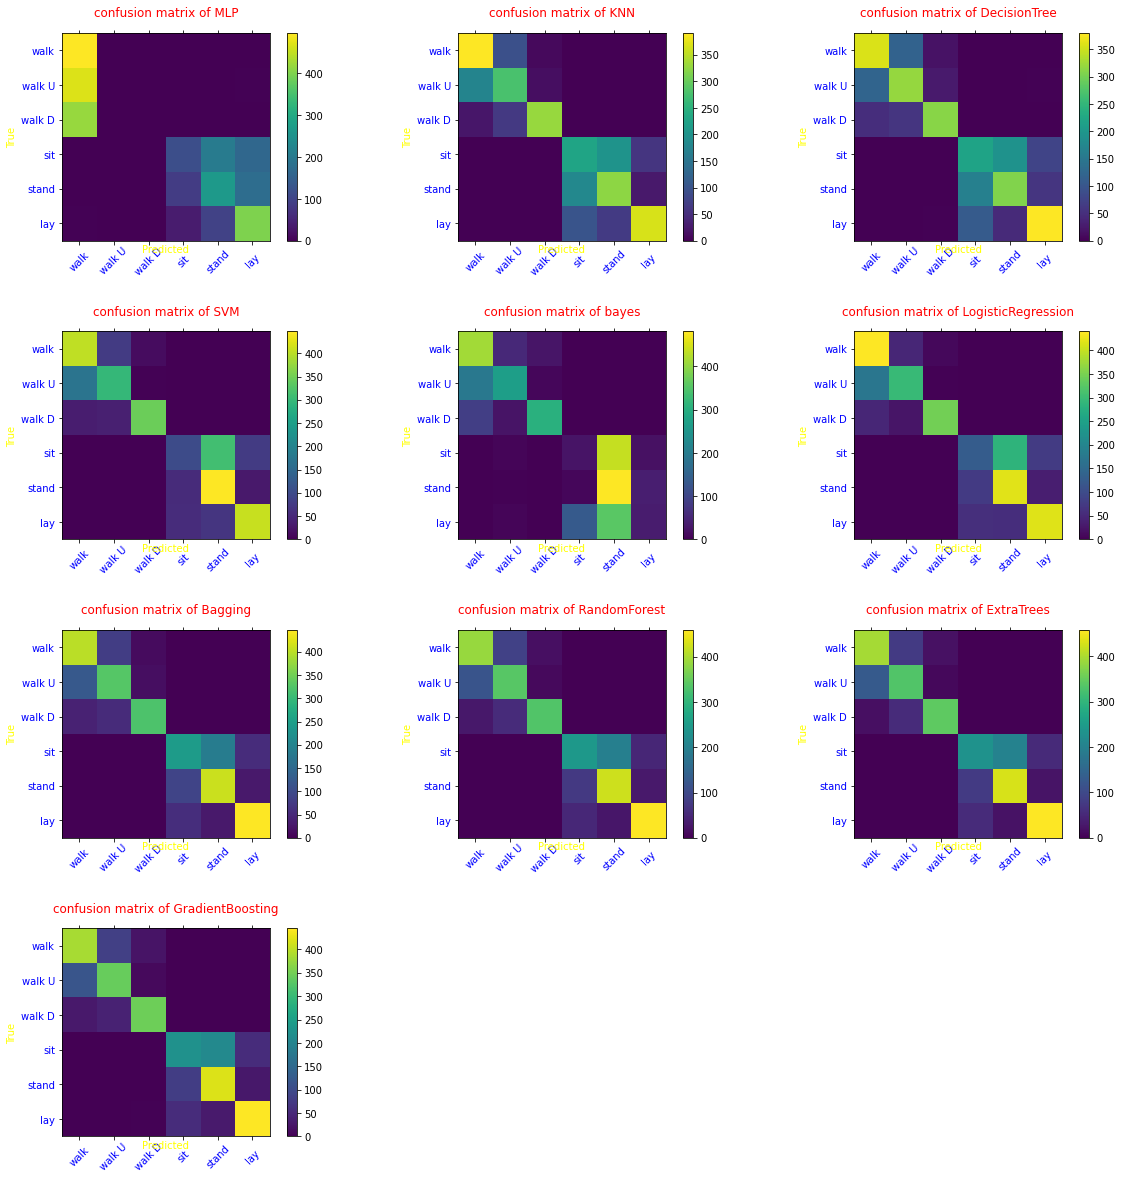

In [148]:
model_names = [name for name,model in models.items() ]
draw_confussion_matrices(testy,cm2,model_names)

In [151]:
models = {}
models['MLP'] = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(64,32,16,8,6), random_state=1,max_iter=2000)
# nonlinear models
models['KNN'] = KNeighborsClassifier(n_neighbors=7)
models['DecisionTree'] = DecisionTreeClassifier()
models['SVM'] = SVC(kernel='rbf')
models['bayes'] = GaussianNB()
models['LogisticRegression'] = LogisticRegression(random_state=0,max_iter=2000)
# ensemble models
models['Bagging'] = BaggingClassifier(n_estimators=100)
models['RandomForest'] = RandomForestClassifier(n_estimators=100)
models['ExtraTrees'] = ExtraTreesClassifier(n_estimators=100)
models['GradientBoosting'] = GradientBoostingClassifier(n_estimators=100)
print('Defined %d models' % len(models))

Defined 10 models


In [154]:
selected_dd = np.concatenate((selected_trainx,selected_testx))
selected_dd_scaled = preprocessing.scale(selected_dd)

trainx_scaled3 = selected_dd_scaled[0:7352]
testx_scaled3 = selected_dd_scaled[7352:10299]

print(trainx_scaled3.shape)
print(testx_scaled3.shape)

result3,cm3 = evaluate_models(trainx_scaled3, trainy.ravel() , testx_scaled3 , testy.ravel() , models)

(7352, 24)
(2947, 24)
>MLP: 37.903
>KNN: 66.339
>DecisionTree: 65.762
>SVM: 70.173
>bayes: 51.985
>LogisticRegression: 71.225
>Bagging: 73.363
>RandomForest: 74.516
>ExtraTrees: 74.449
>GradientBoosting: 73.702


In [156]:
summarize_results(result3)


Name=RandomForest, Score=74.516
Name=ExtraTrees, Score=74.449
Name=GradientBoosting, Score=73.702
Name=Bagging, Score=73.363
Name=LogisticRegression, Score=71.225
Name=SVM, Score=70.173
Name=KNN, Score=66.339
Name=DecisionTree, Score=65.762
Name=bayes, Score=51.985
Name=MLP, Score=37.903


In [0]:
from numpy import dstack

# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

X, y = load_dataset('train', 'UCI HAR Dataset/')

In [158]:
X.shape

(7352, 128, 9)

In [0]:

selected_features = [
    'tBodyAcc-mean()-X',
    'tBodyAcc-mean()-Y',
    'tBodyAcc-mean()-Z',
    'tBodyAcc-min()-X',
    'tBodyAcc-min()-Y',
    'tBodyAcc-min()-Z',
    'tBodyAcc-max()-X',
    'tBodyAcc-max()-Y',
    'tBodyAcc-max()-Z',
    'tBodyAcc-std()-X',
    'tBodyAcc-std()-Y',
    'tBodyAcc-std()-Z',
    
    'tBodyAcc-mad()-X',
    'tBodyAcc-mad()-Y',
    'tBodyAcc-mad()-Z',
    'tBodyAcc-iqr()-X',
    'tBodyAcc-iqr()-Y',
    'tBodyAcc-iqr()-Z',
    'fBodyAcc-skewness()-X',
    'fBodyAcc-skewness()-Y',
    'fBodyAcc-skewness()-Z',
    'fBodyAcc-kurtosis()-X',
    'fBodyAcc-kurtosis()-Y',
    'fBodyAcc-kurtosis()-Z', 


    'tGravityAcc-mean()-X',
    'tGravityAcc-mean()-Y',
    'tGravityAcc-mean()-Z',
    'tGravityAcc-min()-X',
    'tGravityAcc-min()-Y',
    'tGravityAcc-min()-Z',
    'tGravityAcc-max()-X',
    'tGravityAcc-max()-Y',
    'tGravityAcc-max()-Z',
    'tGravityAcc-std()-X',
    'tGravityAcc-std()-Y',
    'tGravityAcc-std()-Z',
    
    'tGravityAcc-mad()-X',
    'tGravityAcc-mad()-Y',
    'tGravityAcc-mad()-Z',
    'tGravityAcc-iqr()-X',
    'tGravityAcc-iqr()-Y',
    'tGravityAcc-iqr()-Z',
    
    
]

In [166]:
selected_featrues_index = find_features_index(features_list,selected_features)
print(len(selected_featrues_index))

42


In [168]:
models = {}
models['MLP'] = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(64,32,16,8,6), random_state=1,max_iter=2000)
# nonlinear models
models['KNN'] = KNeighborsClassifier(n_neighbors=7)
models['DecisionTree'] = DecisionTreeClassifier()
models['SVM'] = SVC(kernel='rbf')
models['bayes'] = GaussianNB()
models['LogisticRegression'] = LogisticRegression(random_state=0,max_iter=2000)
# ensemble models
models['Bagging'] = BaggingClassifier(n_estimators=100)
models['RandomForest'] = RandomForestClassifier(n_estimators=100)
models['ExtraTrees'] = ExtraTreesClassifier(n_estimators=100)
models['GradientBoosting'] = GradientBoostingClassifier(n_estimators=100)
print('Defined %d models' % len(models))


selected_featrues_index = find_features_index(features_list,selected_features)

selected_trainx = trainx[:,selected_featrues_index]
selected_testx = testx[:,selected_featrues_index]

results, cm = evaluate_models(selected_trainx, trainy.ravel() , selected_testx , testy.ravel() , models)
summarize_results(results)


Defined 10 models


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


>MLP: 83.780
>KNN: 82.457
>DecisionTree: 78.147
>SVM: 85.545
>bayes: 76.349
>LogisticRegression: 84.153
>Bagging: 83.169
>RandomForest: 83.882
>ExtraTrees: 85.307
>GradientBoosting: 84.866

Name=SVM, Score=85.545
Name=ExtraTrees, Score=85.307
Name=GradientBoosting, Score=84.866
Name=LogisticRegression, Score=84.153
Name=RandomForest, Score=83.882
Name=MLP, Score=83.780
Name=Bagging, Score=83.169
Name=KNN, Score=82.457
Name=DecisionTree, Score=78.147
Name=bayes, Score=76.349
